In [1]:
using MAT
using NPZ
using Glob
using Dates
using PyCall
using PyPlot
using Eirene
using Random
using Statistics
using Distributions
using DelimitedFiles

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-4151586915025039200\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-4370144319926052618\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-4151586915025039200\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [2]:
macro bash_str(s) open(`bash`,"w",stdout) do io; print(io, s); end; end;

#### Helper functions for rejection sampling

In [3]:
Norm(mu, sigma) = Distributions.Normal(mu, sigma);
Unif(a, b) = Distributions.Uniform(a, b);

function rejection_sample_mvn(num_samples, mu, sigma, current_samples, distance)
    
    i = 1
    rejectcount = 0
    distribution = MvNormal(vec(mu), vec(sigma))
    dimensions = size(current_samples)[2]
    totalsample = Array{Float64}(undef, 0, dimensions)
    
    while(i <= num_samples && rejectcount <= 2000)
        reset = false
        sample = rand(distribution, 1)
        for j in eachrow(totalsample)
            dist = sqrt((j[1] - sample[1])^2 + (j[2] - sample[2])^2)
            if(dist <= distance)
                reset = true; 
                break
            end
        end
        if (reset)
            rejectcount += 1
        else
            sample = transpose(sample)
            totalsample = vcat(totalsample, sample)
            i += 1
        end
    end
    
    if(rejectcount > 2000)
        write(stderr, "WARNING: Exceeded threshold for max. rejections")
    end
    return totalsample
    
end;

function rejection_sample_uniform(num_samples, a, b, current_samples, distance)
    
    i = 1
    rejectcount = 0
    totalsample = current_samples
    
    while(i <= num_samples && rejectcount <= 1000)
        reset = false
        sample = rand(Uniform(a,b), 1, 2)
        for j in eachrow(totalsample)
            dist = sqrt((j[1] - sample[1])^2 + (j[2] - sample[2])^2)
            if(dist <= distance)
                reset = true
                break
            end
        end
        if (reset)
            rejectcount += 1
        else
            totalsample = vcat(totalsample, sample)
            i += 1
        end

    end
    
    if(rejectcount > 1000)
        write(stderr, "WARNING: Exceeded threshold for max. rejections")
    end
    return totalsample
    
end

function rejection_sampling_1d(prob_dist::Function, param1, param2, num_samples, dist_thresh)
    
    cnt = 0
    
    samples = []
    
    num_tries = 0
    max_tries = 1e6
    
    while cnt < num_samples
        
        if num_tries >= max_tries
            print("ERROR: Exceeded max. tries after sampling " * string(cnt) * "/" * string(num_samples))
            return nothing
        end
        
        new_sample = rand(prob_dist(param1, param2), 1)[1]
        
        if length(samples) > 0
            if sum(abs.(new_sample .- samples) .< dist_thresh) == 0
                push!(samples, new_sample)
                cnt += 1
            end
        else
            push!(samples, new_sample)
            cnt += 1
        end
        
        num_tries += 1
        
    end
    
    return samples
    
end;

#### Plotting

In [4]:
function plot_syn_data(cell_pos, cell_type)
    
    figure(figsize=(5,5), dpi=200)
    
    num_cells = size(cell_type)[1]
    for cid in range(1, stop=num_cells)
        if cell_type[cid] == 1.0
            scatter(cell_pos[cid,1], cell_pos[cid,2], 6, color = "dimgray")
        elseif cell_type[cid] == 2
            scatter(cell_pos[cid,1], cell_pos[cid,2], 6, color = "gold")
        else
            scatter(cell_pos[cid,1], cell_pos[cid,2], 6, color = "blue")
            write(stderr, "WARNING: More than 2 cell types")
        end                
    end
    
    xlim([-10, 10])
    ylim([-10, 10])
    xticks([])
    yticks([])
    
end;

#### Poisson disk sampling

Reference: https://scipython.com/blog/poisson-disc-sampling-in-python/

In [5]:
py"""

import numpy as np

def get_cell_coords(pt, a):

    return int(pt[0] // a), int(pt[1] // a)

def get_neighbours(coords, nx, ny, cells):

    dxdy = [(-1,-2),(0,-2),(1,-2),(-2,-1),(-1,-1),(0,-1),(1,-1),(2,-1),
            (-2,0),(-1,0),(1,0),(2,0),(-2,1),(-1,1),(0,1),(1,1),(2,1),
            (-1,2),(0,2),(1,2),(0,0)]
    neighbours = []
    for dx, dy in dxdy:
        neighbour_coords = coords[0] + dx, coords[1] + dy
        if not (0 <= neighbour_coords[0] < nx and
                0 <= neighbour_coords[1] < ny):
            continue
        neighbour_cell = cells[neighbour_coords]
        if neighbour_cell is not None:
            neighbours.append(neighbour_cell)

    return neighbours

def point_valid(pt, r, a, nx, ny, cells, samples):

    cell_coords = get_cell_coords(pt, a)
    for idx in get_neighbours(cell_coords, nx, ny, cells):
        nearby_pt = samples[idx]
        distance2 = (nearby_pt[0]-pt[0])**2 + (nearby_pt[1]-pt[1])**2
        if distance2 < r**2:
            return False

    return True

def get_point(k, refpt, r, a, width, height, nx, ny, cells, samples):

    i = 0
    while i < k:
        rho, theta = np.random.uniform(r, 2*r), np.random.uniform(0, 2*np.pi)
        pt = refpt[0] + rho*np.cos(theta), refpt[1] + rho*np.sin(theta)
        if not (0 <= pt[0] < width and 0 <= pt[1] < height):
            continue
        if point_valid(pt, r, a, nx, ny, cells, samples):
            return pt
        i += 1
    return False


def poi_disk_sample(k, r, width, height, rng_seed):

    np.random.seed(rng_seed)

    a = r/np.sqrt(2)
    nx, ny = int(width / a) + 1, int(height / a) + 1
    coords_list = [(ix, iy) for ix in range(nx) for iy in range(ny)]
    cells = {coords: None for coords in coords_list}

    pt = (np.random.uniform(0, width), np.random.uniform(0, height))
    samples = [pt]
    cells[get_cell_coords(pt,a)] = 0
    active = [0]

    nsamples = 1

    while active:

        idx = np.random.choice(active)
        refpt = samples[idx]
        pt = get_point(k, refpt, r, a, width, height, nx, ny, cells, samples)
        if pt:
            samples.append(pt)
            nsamples += 1
            active.append(len(samples)-1)
            cells[get_cell_coords(pt,a)] = len(samples) - 1
        else:
            active.remove(idx)

    return samples

"""

#### Simulate Zebrafish skin pigmentation configurations

In [6]:
function generate_fixed_spots(num_spots, tot_num_cells, spot_num_cells, spot_width_mu, spot_width_var, 
                              spot_cell_type, position_seed, param_seed, r)
    
    o_type = 1
    if spot_cell_type == 1
       o_type = 2 
    end
    
    # allocate space
    spot_pop = floor(Int, spot_num_cells/num_spots)
    spot_pos = Array{Float64}(undef, num_spots, spot_pop, 2)
    cellpos = Array{Float64}(undef, 0, 2)
    celltypes = ones(spot_pop*num_spots) * spot_cell_type
    
    # seed RNG to pick spot locations
    Random.seed!(position_seed)
    
    # pick spot locations
    clustercenter = Array{Float64}(undef, num_spots, 2)
    locations = py"poi_disk_sample"(30, r, 18, 18, position_seed)
    locations = shuffle(locations)
    for i in 1:num_spots
        a,b = locations[i]
        clustercenter[i,1] = a - 9
        clustercenter[i,2] = b - 9
    end

    # shuffle cluster centers
    clustercenter = clustercenter[shuffle(1:end), :]
    
    # seed RNG to pick cell positions
    Random.seed!(param_seed)
    
    for i in 1:num_spots
        sigma = rand(Normal(spot_width_mu, spot_width_var), 1, 2)
        tempcellpos = rejection_sample_mvn(spot_pop, clustercenter[i,:], sigma, cellpos, 0.05)
        cellpos = vcat(cellpos, tempcellpos)
        spot_pos[i,:,1] = tempcellpos[:,1]
        spot_pos[i,:,2] = tempcellpos[:,2]
    end

    # sample cells of the other type
    cellpos = rejection_sample_uniform(tot_num_cells -  spot_pop*num_spots, -10, 10, cellpos, 0.3)
    celltypes = vcat(celltypes, o_type*ones(tot_num_cells - spot_pop*num_spots, 1))
    
    return (cellpos, celltypes, spot_pos, clustercenter, locations)

end;

#### Helper methods to calculate stripe statistics

In [7]:
function pairwise_euclidean(X)
    
    num_samples = size(X)[1]
    num_feats = size(X)[2]
    
    D = Array{Float64}(undef, num_samples, num_samples)
    
    for i in range(1, stop=num_samples)
        
        j = 1
        while (j < i)
            
            d = 0.0
            for k in range(1, stop=num_feats)
                d += (X[i,k] - X[j,k])^2
            end
            
            D[i,j] = sqrt(d) 
            D[j,i] = D[i,j]
            j += 1
            
        end
        
        D[i,i] = 0.0
        
    end
    
    return D
    
end;


function interparticle_dist2(stripe_data)

    avg_cell_distance = 0.0

    num_cells = 0
    for s in range(1, stop=size(stripe_data)[1])

        D = pairwise_euclidean(stripe_data[s])

        avg_cell_distance += sum(sort(D, dims=2)[:,2])   ## fixme
        num_cells += size(D)[1]

    end

    avg_cell_distance /= num_cells
    
    return avg_cell_distance
    
end;


function interstripe_dist2(stripe_data)
    
    avg_stripe_distance = 0.0
    num_cells = 0
    for s1 in range(1, stop=size(stripe_data)[1])
        for cellstripe in range(1,stop = size(stripe_data[s1])[1])
            cell_pos = stripe_data[s1][cellstripe, :]
            alldist = []
            for s2 in range(1, stop=size(stripe_data)[1])
                if s2!=s1
                    for cellstripe2 in range(1, stop = size(stripe_data[s2])[1])
                        cell_pos2 = stripe_data[s2][cellstripe2, :]
                        d = 0.0
                        for j in range(1, stop= size(cell_pos)[1])
                            d += (cell_pos[j] - cell_pos2[j])^2
                        end
                        push!(alldist, sqrt(d))
                    end
                end
            end
            avg_stripe_distance += minimum(alldist)
            num_cells += 1
        end
    end
    avg_stripe_distance /= num_cells
    
    return avg_stripe_distance
    
end;

#### Number of Spots

In [8]:
spots = 5:2:25;

In [9]:
bash""" 
rm -rf spot_num
mkdir spot_num
"""

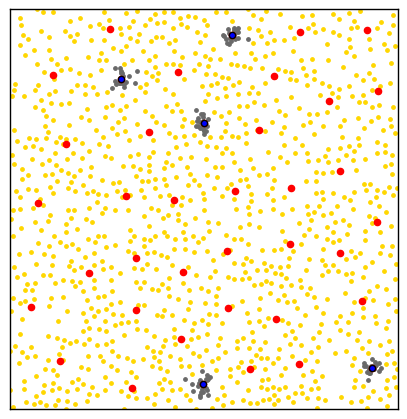

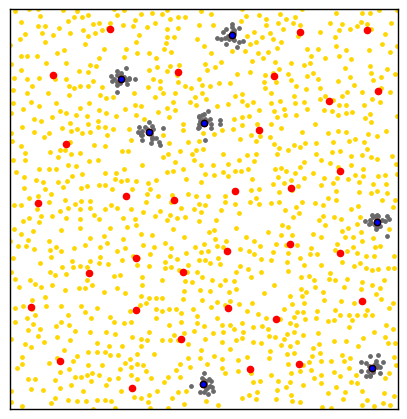

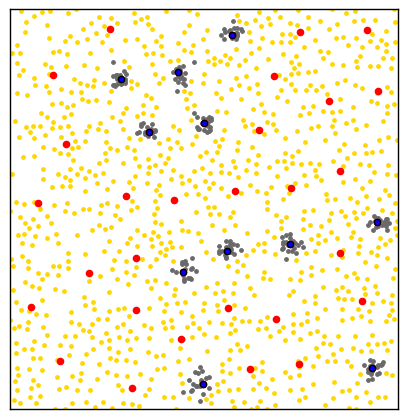

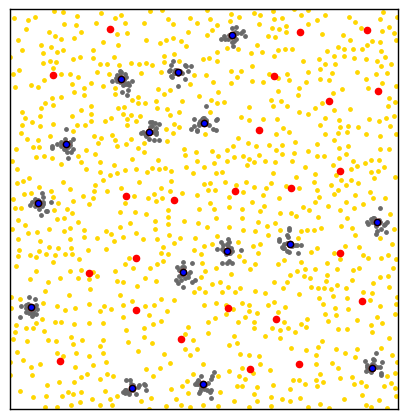

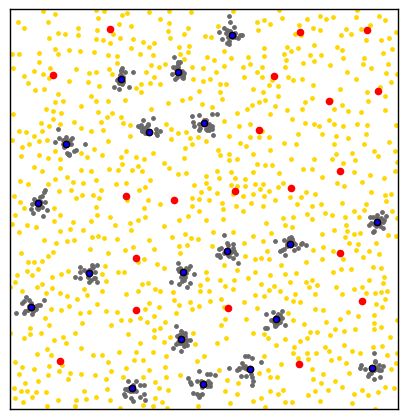

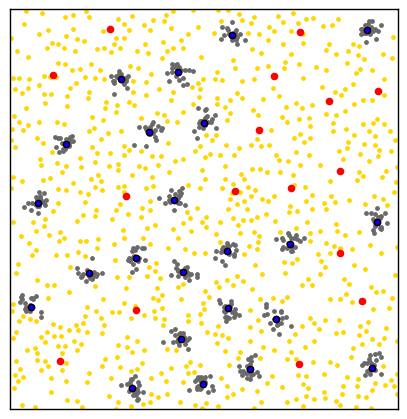

In [10]:
num_reps = 5
plot_candidates = true

parent_folder = "spot_num"

for rep in 1:num_reps
    
    storage_folder = parent_folder * "/" * string(rep)
    
    mkdir(storage_folder)

    spot_pos_seed = Int(floor(datetime2unix(now())))
    
    tot_num_cells = 1200
    spot_width_mu = 0.3
    spot_width_var = 0.01
    
    for itr in range(1, stop=length(spots))
        
        spot_store = []
        num_spots = spots[itr]
        spot_num_cells = 20*num_spots
        
        cell_pos_seed = Int(floor(datetime2unix(now())))
        
        (cell_pos, cell_types, spot_pos, cluster_pos, all_loc) = generate_fixed_spots(num_spots, tot_num_cells, 
                                                            spot_num_cells, spot_width_mu, spot_width_var, 
                                                            1, spot_pos_seed, cell_pos_seed, 2.5)
        
        for i in 1:num_spots
            push!(spot_store, spot_pos[i,:,:])
        end
        
        if rep == 1
            if itr == 1 || itr % 2 == 0
                plot_syn_data(cell_pos, cell_types)
                if plot_candidates
                    for i in range(1, stop=length(all_loc))
                        xc,yc = all_loc[i]
                        scatter(xc-9, yc-9, color="red")
                    end
                    scatter(cluster_pos[:,1], cluster_pos[:,2])
                end
            end
        end
        
        filename = storage_folder * "/wspots_" * string(spot_pos_seed) * "_" * string(itr) * ".npz"

        file_dict = Dict("pos" => cell_pos, "types" => cell_types, "spot_pos_seed" => spot_pos_seed, 
                        "cell_pos_seed" => cell_pos_seed, "num_spots" => num_spots,
                        "spot_width_mu" => spot_width_mu, "spot_width_var" => spot_width_var,
                        "interparticle_dist_avg" => interparticle_dist2(spot_store),
                        "interstripe_dist_avg" => interstripe_dist2(spot_store))
                    
        npzwrite(filename, file_dict)

        sleep(1)
        
    end
    
end

#### Variance in Spot Size

In [20]:
spot_var = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5];

In [21]:
bash""" 
rm -rf spot_var
mkdir spot_var
"""

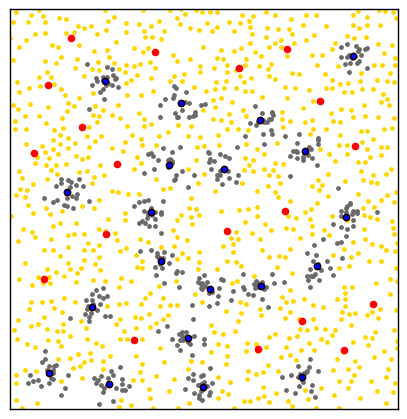

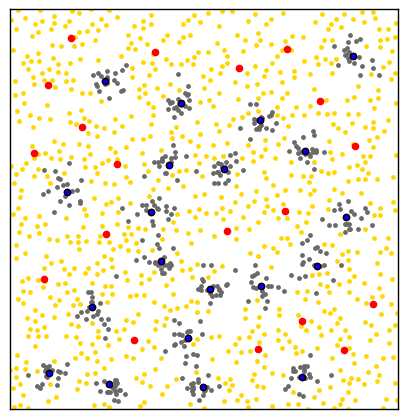

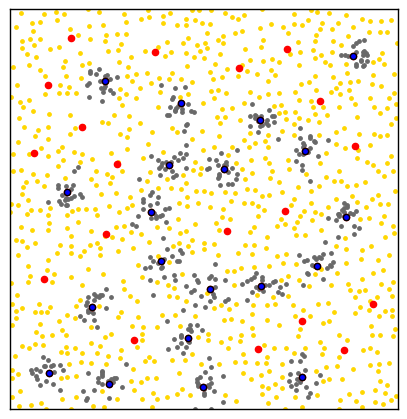

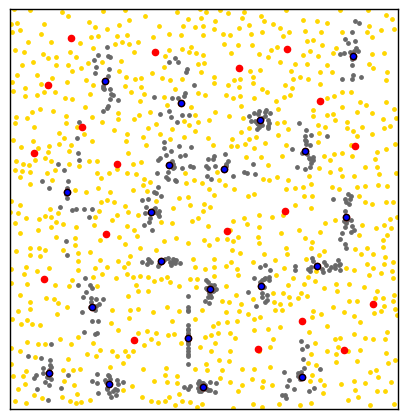

In [22]:
num_reps = 5
plot_candidates = true

parent_folder = "spot_var"

for rep in 1:num_reps
    
    storage_folder = parent_folder * "/" * string(rep)
    
    mkdir(storage_folder)

    spot_pos_seed = Int(floor(datetime2unix(now())))
    
    tot_num_cells = 1200
    num_spots = 20
    spot_width_mu = 0.5

    for itr in range(1, stop=length(spot_var))
        
        spot_store = []
        spot_width_var = spot_var[itr]
        spot_num_cells = 20*num_spots
        
        cell_pos_seed = Int(floor(datetime2unix(now())))
        
        (cell_pos, cell_types, spot_pos, cluster_pos, all_loc) = generate_fixed_spots(num_spots, tot_num_cells, 
                                                                spot_num_cells, spot_width_mu, spot_width_var, 
                                                                1, spot_pos_seed, cell_pos_seed, 2.5)
        
        for i in 1:num_spots
            push!(spot_store, spot_pos[i,:,:])
        end
        
        if rep == 1
            if itr == 1 || itr % 2 == 0
                plot_syn_data(cell_pos, cell_types)
                if plot_candidates
                    for i in range(1, stop=length(all_loc))
                        xc,yc = all_loc[i]
                        scatter(xc-9, yc-9, color="red")
                    end
                    scatter(cluster_pos[:,1], cluster_pos[:,2])
                end
            end
        end
        
        filename = storage_folder * "/wspots_" * string(spot_pos_seed) * "_" * string(itr) * ".npz"
        
        file_dict = Dict("pos" => cell_pos, "types" => cell_types, "spot_pos_seed" => spot_pos_seed, 
                        "cell_pos_seed" => cell_pos_seed, "num_spots" => num_spots,
                        "spot_width_mu" => spot_width_mu, "spot_width_var" => spot_width_var,
                        "interparticle_dist_avg" => interparticle_dist2(spot_store),
                        "interstripe_dist_avg" => interstripe_dist2(spot_store))
                    
        npzwrite(filename, file_dict)

        sleep(1)
        
    end
    
end

#### Mean Spot Size

In [14]:
spot_mu = [0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75];

In [15]:
bash""" 
rm -rf spot_mu
mkdir spot_mu
"""

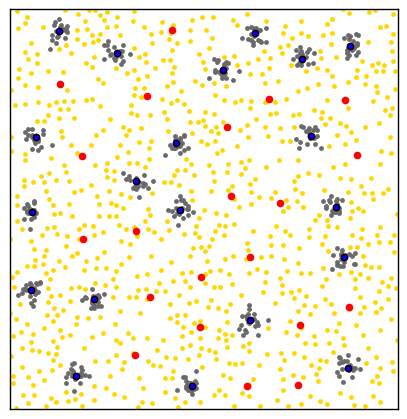

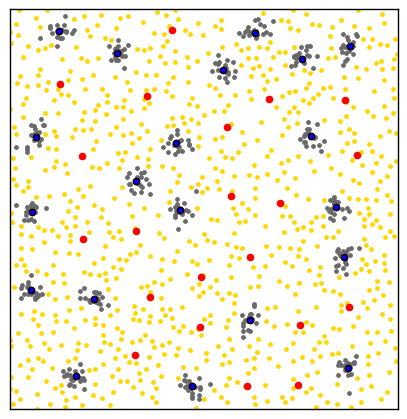

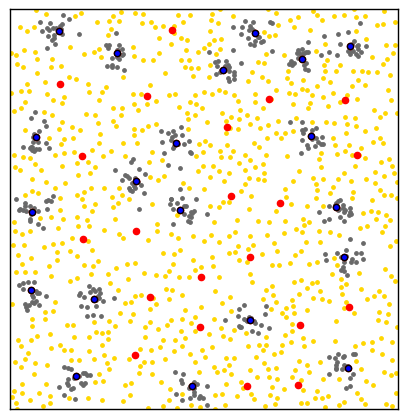

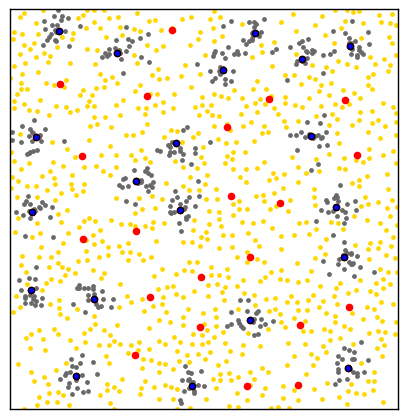

In [16]:
num_reps = 5
plot_candidates = true

parent_folder = "spot_mu"

for rep in 1:num_reps
    
    storage_folder = parent_folder * "/" * string(rep)
    
    mkdir(storage_folder)

    spot_pos_seed = Int(floor(datetime2unix(now())))
    
    tot_num_cells = 1200
    num_spots = 20
    spot_width_var = 0.01
    
    for itr in range(1, stop=length(spot_var))
        
        spot_store = []
        spot_width_mu = spot_mu[itr]
        spot_num_cells = 20*num_spots
        
        cell_pos_seed = Int(floor(datetime2unix(now())))
        
        (cell_pos, cell_types, spot_pos, cluster_pos, all_loc) = generate_fixed_spots(num_spots, tot_num_cells, 
                                                                spot_num_cells, spot_width_mu, spot_width_var, 
                                                                1, spot_pos_seed, cell_pos_seed, 2.5)
        
        for i in 1:num_spots
            push!(spot_store, spot_pos[i,:,:])
        end
        
        if rep == 1
            if itr == 1 || itr % 2 == 0
                plot_syn_data(cell_pos, cell_types)
                if plot_candidates
                    for i in range(1, stop=length(all_loc))
                        xc,yc = all_loc[i]
                        scatter(xc-9, yc-9, color="red")
                    end
                    scatter(cluster_pos[:,1], cluster_pos[:,2])
                end
            end
        end
        
        filename = storage_folder * "/wspots_" * string(spot_pos_seed) * "_" * string(itr) * ".npz"
        
        file_dict = Dict("pos" => cell_pos, "types" => cell_types, "spot_pos_seed" => spot_pos_seed, 
                        "cell_pos_seed" => cell_pos_seed, "num_spots" => num_spots,
                        "spot_width_mu" => spot_width_mu, "spot_width_var" => spot_width_var,
                        "interparticle_dist_avg" => interparticle_dist2(spot_store),
                        "interstripe_dist_avg" => interstripe_dist2(spot_store))
                    
        npzwrite(filename, file_dict)

        sleep(1)
        
    end
    
end

#### Spot Density

In [17]:
spot_density = 10:10:80;

In [18]:
bash""" 
rm -rf spot_density
mkdir spot_density
"""

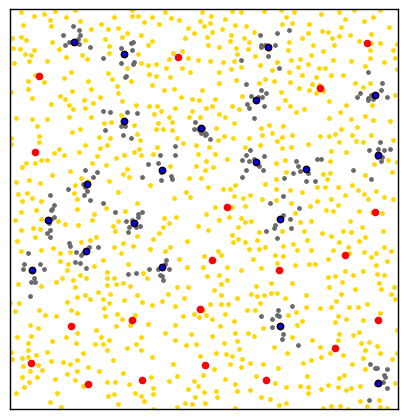

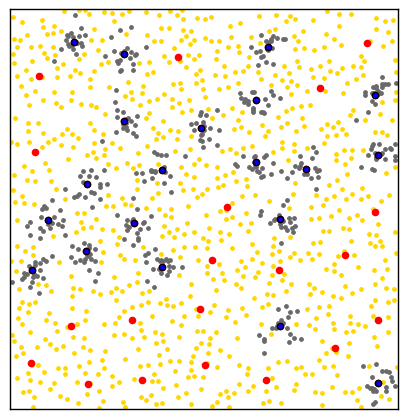

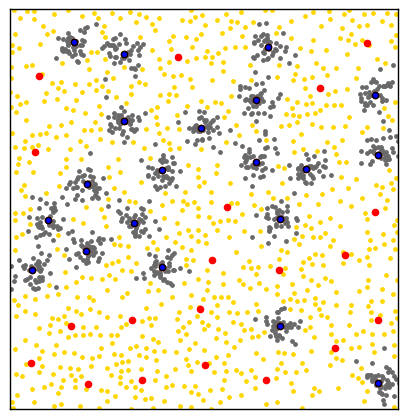

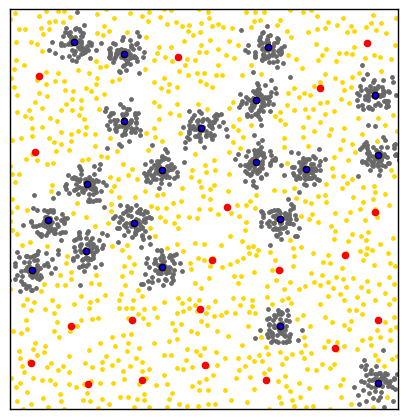

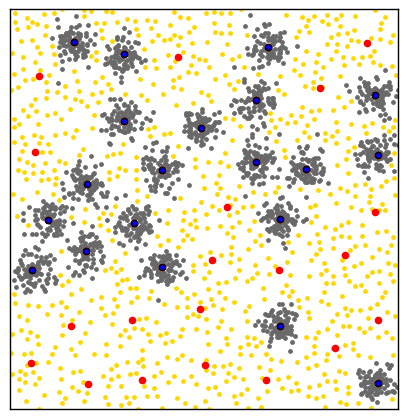

In [19]:
num_reps = 5
plot_candidates = true

parent_folder = "spot_density"

for rep in 1:num_reps
    
    storage_folder = parent_folder * "/" * string(rep)
    
    mkdir(storage_folder)

    spot_pos_seed = Int(floor(datetime2unix(now())))
    
    num_bg_cells = 800
    num_spots = 20
    spot_width_mu = 0.5
    spot_width_var = 0.01
    
    for itr in range(1, stop=length(spot_density))
        
        spot_store = []
        spot_num_cells = spot_density[itr]*num_spots
        
        tot_num_cells = spot_num_cells + num_bg_cells
        
        cell_pos_seed = Int(floor(datetime2unix(now())))
        
        (cell_pos, cell_types, spot_pos, cluster_pos, all_loc) = generate_fixed_spots(num_spots, tot_num_cells, 
                                                                spot_num_cells, spot_width_mu, spot_width_var, 
                                                                1, spot_pos_seed, cell_pos_seed, 2.5)
        
        for i in 1:num_spots
            push!(spot_store, spot_pos[i,:,:])
        end
        
        if rep == 1
            if itr == 1 || itr % 2 == 0
                plot_syn_data(cell_pos, cell_types)
                if plot_candidates
                    for i in range(1, stop=length(all_loc))
                        xc,yc = all_loc[i]
                        scatter(xc-9, yc-9, color="red")
                    end
                    scatter(cluster_pos[:,1], cluster_pos[:,2])
                end
            end
        end
        
        filename = storage_folder * "/wspots_" * string(spot_pos_seed) * "_" * string(itr) * ".npz"
        
        file_dict = Dict("pos" => cell_pos, "types" => cell_types, "spot_pos_seed" => spot_pos_seed, 
                        "cell_pos_seed" => cell_pos_seed, "num_spots" => num_spots,
                        "spot_width_mu" => spot_width_mu, "spot_width_var" => spot_width_var,
                        "interparticle_dist_avg" => interparticle_dist2(spot_store),
                        "interstripe_dist_avg" => interstripe_dist2(spot_store))
                    
        npzwrite(filename, file_dict)

        sleep(1)
        
    end
    
end